## Spacers sequence features
(See fetch_real_data.ipynb prior to this notebook for getting and indexing the actual spacers).  

In our benchmark, we'll use the CRISPR sapcer set from [iphop](https://bitbucket.org/srouxjgi/iphop/src/main/#markdown-header-host-databases-and-versions) (June 2025 upload).  
In a preprint version of this project we used the IMG/VR4 spacer set, but we've observed that set is less curated (e.g. the sequence size ranges way above known spacers length).  
In this notebook we'll inspect the iphop set for potential issues, measure noteable sequence characteristics (nucleobase composition, length range and distribution type, amount of low complexity subsequence...). We will also demonstrate that the rust based sequence simulator we build can generate spacer and contig sequences rougly matching these features.  

-  Low complexity sequences (low shannon entropy, low lcc value, presence of dustmasked/ambiguous bases...)
-  Relative base composition
-  Distribution of kmers (uniqueness and repeatability, 2<= k <= 6)  

**Note:** iphop as a tool (not a DB) has some internal filtering of low complexity spacers, but it is done post-hoc (after spacer-protospacer matching).  
We are testing multiple tools, that treat complexity differently (or not at all), so we'll not adjust the set too much, altough it is definetly a heavly recommended suggestion in a host prediction use case (rather than a benchmarking one).   
So to avoid having the benchmark skewed by the tool-specific low complexity handling (*some tools allow disabling this (e.g. in blastn, `-dust no`), and some tools use different algorithms (dust, tantan, entropy etc)), we will remove some obvious outlier spacers (~0.81% of the spacers), namely:  
- with ambigious bases (N),
- very low entropy (<1),
- highly skewed base composition (>98% of the sequence being from the same charcater)
- with any 6mer repeated more than 4 times.

We also won't go into why certain spacers are low quality, as that is out of scope for this work. the iphop DB is made using CRISPR array extraction tools (like pilercr and CRT), which may misdetect certain non-CRISPR repeat sequences as such.  


In [51]:
import os
os.chdir('/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/imgvr4_data/') # needed as it's easier to use relative paths without ../ everytime.
import json
import polars as pl
import pydustmasker as pdm
import matplotlib.pyplot as plt
import seaborn as sns
from bench import *
from bench.utils.functions import  read_fasta_needletail, calculate_shannon_entropy, lcc_simp #, lcc_mult, filter_repetitive_kmers
import numpy as np

pl.Config(tbl_rows=50)
plots_dir = '/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/plots/'
# Load your custom color palette
with open('../notebooks/antonio_14_colors.json', 'r') as f:
    color_data = json.load(f)
# Set the color palette globally
custom_colors = color_data['hex_colors']
sns.set_palette(custom_colors)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)
    
spacers_file = 'spacers/All_CRISPR_spacers_nr_clean.fna'
spacer_df = pl.DataFrame(read_fasta_needletail(spacers_file), schema={'seqid': pl.Utf8, 'seq': pl.Utf8},)
spacer_df = spacer_df.with_columns(
    pl.col("seq").str.len_chars().alias("length")
    )
spacer_df = spacer_df.with_columns(
    (pl.col("seq").str.count_matches("G|C|g|c")/pl.col("length")).alias("gc_frac"))

### Some basics
First, let's see the total size of the set and the ranges of lengths and per-base frequencies (and GC precentage).

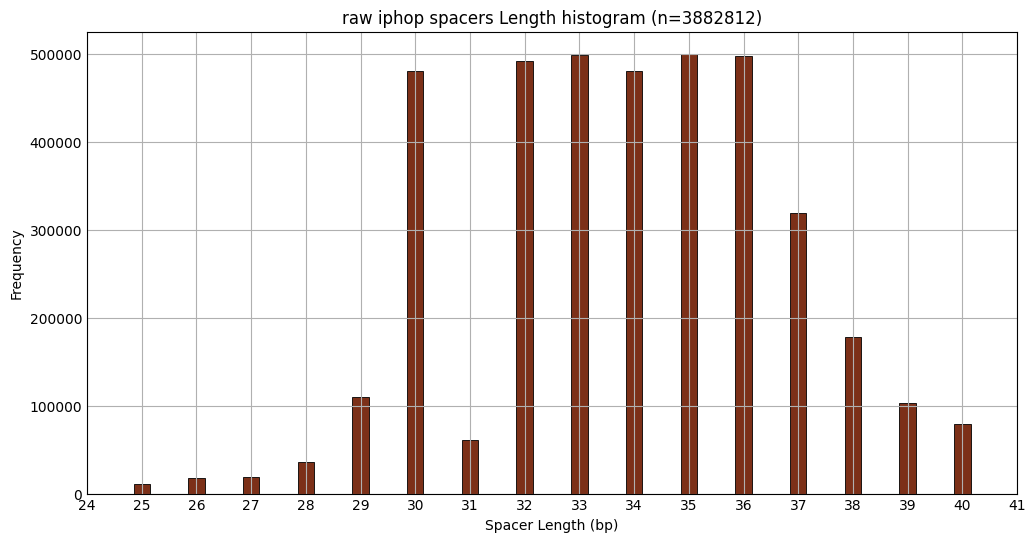

In [52]:
length_bins = np.arange(25, 42, 1)
gc_bins = np.arange(0, 1.01, 0.01)
fig, axes = plt.subplots(figsize=(12, 6))
axes.hist(spacer_df["length"], bins=length_bins, edgecolor='black', linewidth=0.6, rwidth=0.3, align='left')
axes.set_title(f'raw iphop spacers Length histogram (n={spacer_df.height})')
axes.set_xlabel('Spacer Length (bp)')
axes.set_ylabel('Frequency')
# show grid
axes.grid(True)
# show ticks for all x values
axes.set_xticks(spacer_df["length"].unique().to_list() + [24,41])

# show ticks labels
axes.tick_params(axis='both', which='both', length=0)
plt.savefig(plots_dir + 'raw_all_spacers_length_distributions.svg')
plt.show()

### Relative base composition of the spacers (fraction of the each base out of the total number of bases in each spacer).

In [53]:
spacer_df = spacer_df.with_columns(
    (pl.col("seq").str.count_matches("N|n")/pl.col("length")).alias("n_frac"),
    (pl.col("seq").str.count_matches("A|a")/pl.col("length")).alias("a_frac"),
    (pl.col("seq").str.count_matches("T|t")/pl.col("length")).alias("t_frac"),
    (pl.col("seq").str.count_matches("C|c")/pl.col("length")).alias("c_frac"),
    (pl.col("seq").str.count_matches("G|g")/pl.col("length")).alias("g_frac"),
)
# spacer_df = spacer_df.sort("t_frac", descending=True)

### Plots 

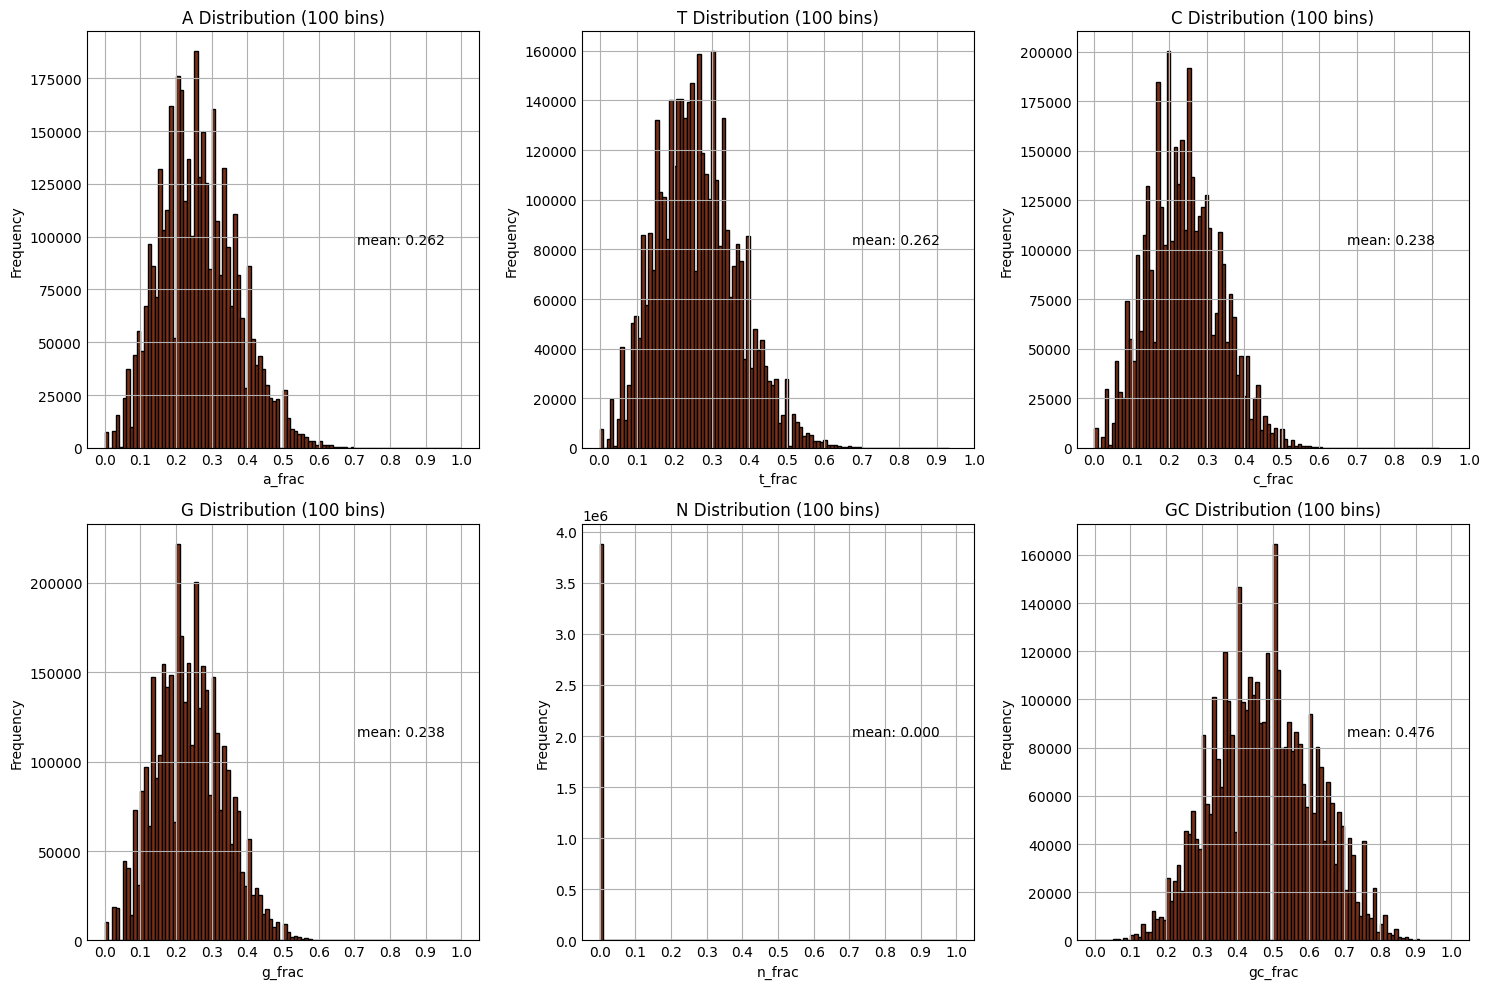

Nucleobase Stats:
shape: (9, 7)
┌────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┐
│ statistic  ┆ a_frac     ┆ t_frac     ┆ c_frac     ┆ g_frac     ┆ n_frac     ┆ gc_frac    │
│ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│ str        ┆ f64        ┆ f64        ┆ f64        ┆ f64        ┆ f64        ┆ f64        │
╞════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╡
│ count      ┆ 3.882812e6 ┆ 3.882812e6 ┆ 3.882812e6 ┆ 3.882812e6 ┆ 3.882812e6 ┆ 3.882812e6 │
│ null_count ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        │
│ mean       ┆ 0.261702   ┆ 0.261751   ┆ 0.238359   ┆ 0.238039   ┆ 0.000147   ┆ 0.476399   │
│ std        ┆ 0.107613   ┆ 0.107737   ┆ 0.096436   ┆ 0.09656    ┆ 0.010133   ┆ 0.142907   │
│ min        ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        │
│ 25%        ┆ 0.181818   ┆ 0.181818  

In [54]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

bases = ["a_frac", "t_frac", "c_frac", "g_frac", "n_frac", "gc_frac"]
bins = 100
for idx, base in enumerate(bases):
    axes[idx].hist(spacer_df[base], bins=bins, edgecolor='black')
    axes[idx].set_title(f'{base.split("_")[0].upper()} Distribution ({bins} bins)')
    axes[idx].grid(True)
    axes[idx].set_xticks(np.arange(0, 1.01, 0.1))
    axes[idx].set_xlabel(base)
    axes[idx].set_ylabel('Frequency')
    axes[idx].text(0.8, 0.5, f'mean: {spacer_df[base].mean():.3f}', 
                    ha='center', va='center', transform=axes[idx].transAxes)
    axes[idx].tick_params(axis='both', which='both', length=0)

plt.tight_layout()
plt.savefig(plots_dir + 'raw_base_fractions_distributions.svg')
plt.show()

print("Nucleobase Stats:")
print(spacer_df[bases].describe())


### Ambiguous base presence
The N fraction from above is small but not 0. as a precaution, we'll mark these with a column.


In [55]:
spacer_df = spacer_df.with_columns(
    pl.when(pl.col("n_frac") > 0).then(True).otherwise(False).alias("has_n"))
spacer_df["has_n"].value_counts(normalize=True)

has_n,proportion
bool,f64
false,0.999675
true,0.000325


### Shannon entropy
Calculating the Shannon entropy of each spacer sequence.  

The Shannon entropy formula for an entire sequenceis $H = -\sum p_{i}\log _{2}p_{i}$   
where $p_{i}$ is the probability of character $i$ in the spacer sequence.


In [56]:
spacer_df = spacer_df.with_columns(
    pl.col("seq").map_elements(calculate_shannon_entropy, return_dtype=pl.Float64).alias("entropy")
)
spacer_df["entropy"].describe()

statistic,value
str,f64
"""count""",3.882812e6
"""null_count""",0.0
"""mean""",1.872601
"""std""",0.107339
"""min""",0.0
"""25%""",1.825323
"""50%""",1.900292
"""75%""",1.948929
"""max""",3.253259


An plotting the histogram of the entropy values to see the distribution.

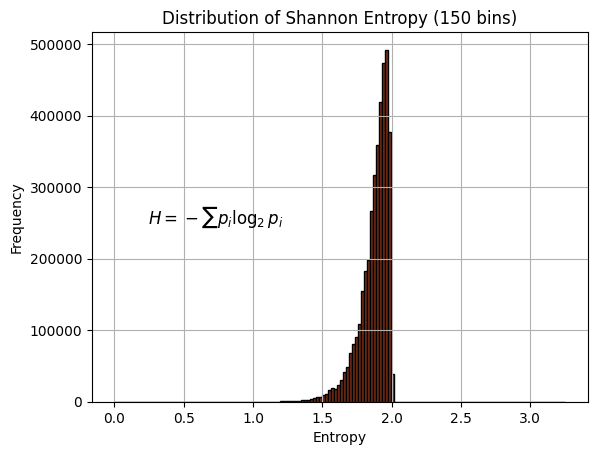

In [57]:
plt.grid(True)
plt.hist(spacer_df["entropy"], bins=150, edgecolor='black')
plt.title('Distribution of Shannon Entropy (150 bins)')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.text(0.25, 0.5, '$H = -\sum p_{i}\log_{2} p_{i}$', ha='center', va='center', transform=plt.gca().transAxes,fontsize=12)
plt.savefig(plots_dir + 'raw_spacers_entropy_distribution.svg')
plt.show()

### Reapeted kmer compositions

The Shannon entrophy metric doesn't take into account the base order: `aaaaaatttttttgggggcccccc` and `ccccattaaaacggcgttgtgatt` will have the same value, even thouse the first one is less complex.  
Because of this, we'll examine if the spacers how much "repeatations" (appearing multiple times) substrings of lengths 3-8 are in our spacers. For the example above, if we use k=3, we get:
| seq | kmer_3_counts |
|-----|---------------|
| `aaaaaatttttttgggggcccccc` | `aat': 1,tgg: 1,ggg: 3,aaa: 4,ttg: 1,ccc: 4,ttt: 5,gcc: 1,att: 1,ggc: 1` |
| `ccccattaaaacggcgttgtgatt` | `ccc: 2,att: 2,aaa: 2,cca: 1,cat: 1,tta: 1,taa: 1,aac: 1,acg: 1,cgg: 1,ggc: 1,gcg: 1,cgt: 1,gtt: 1,ttg: 1,tgt: 1,gtg: 1,tga: 1,gat: 1` |
  
<!-- And the mean of the counts for the first is:
$\frac{1 + 1 + 3 + 4 + 1 + 4 + 5 + 1 + 1 + 1}{10} = \frac{22}{10} = 2.2$  
And for the second:
$\frac{2 + 2 + 2 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 }{19} = \frac{22}{19} = 1.157895$  

*Notice* the **denominator** is larger for the second sequence, as there are more unique 3mers.
 -->
As this is some what length dependent, we will simplify it by just saving the number of non-unique kmers (those with count > 1) for each kmer size, for each spacer.

<!-- 
# import random
example_seq = "aaaaaatttttttgggggcccccc"
# new_seq = "".join(random.sample(example_seq, len(example_seq))) # only needed this to run once
new_seq ="ccccattaaaacggcgttgtgatt"
seq_df = pl.DataFrame({"seq": [example_seq, new_seq], "seqid": ["example_seq", "new_seq"]})
seq_df = seq_df.with_columns(   
    pl.col("seq").map_elements(calculate_shannon_entropy, return_dtype=pl.Float64).alias("entropy")
)
seq_df = count_kmers_df(seq_df, "seq", "seqid", 3, relative=False)
seq_df = seq_df.with_columns(
    pl.col('kmer_3_counts').list.eval(
        pl.element().struct.field('count').mean()
    ).alias("mean_kmer_3_counts")
)

print(seq_df)
#  kmer_3_counts so the table has two columns: "count" and "kmer"
# Create the kmer table by exploding and unnesting properly
kmer_table = seq_df.select(
    pl.col("seqid"),
    pl.col("kmer_3_counts")
).explode("kmer_3_counts").unnest("kmer_3_counts").rename({"substrings": "kmer"})

print("\nK-mer table with count and kmer columns:")
print(kmer_table) -->

So next, we will to the table columns with the 3-7mers counts, to get an idea of the repeateveness of the spacers.

In [58]:
for k in range(3, 7):
    tmp_df = count_kmers_df_explicit(spacer_df, "seq", "seqid", k, relative=False)
    tmp_df = tmp_df.select(pl.col("seqid"),
        pl.col(f"kmer_{k}_counts").list.eval(
            (pl.element().struct.field("count") > 1).sum()
        ).list.first().alias(f"n_nonunique_kmer_{k}"),
    )
    spacer_df = spacer_df.join(
        tmp_df,
        on="seqid",
        how="left"
    )
    del tmp_df # this can get big, and python GC won't know we treat it as a tmp variable...
    print(f"k={k} done")

k=3 done
k=4 done
k=5 done
k=6 done


Converting to "long" format for easier plotting...

In [59]:
# Reshape data for plotting 
ks = [3,4,5,6]
exp = []
for k in ks:
    exp.append(
        spacer_df.select([
            pl.col("seqid"),
            pl.col(f"n_nonunique_kmer_{k}").alias("n_nonunique"),
            pl.col("length").alias("length"),
            pl.lit(k).alias("k_length")
        ])
    )
kmer_long = pl.concat(exp)

Some box plots for k-mer statistics

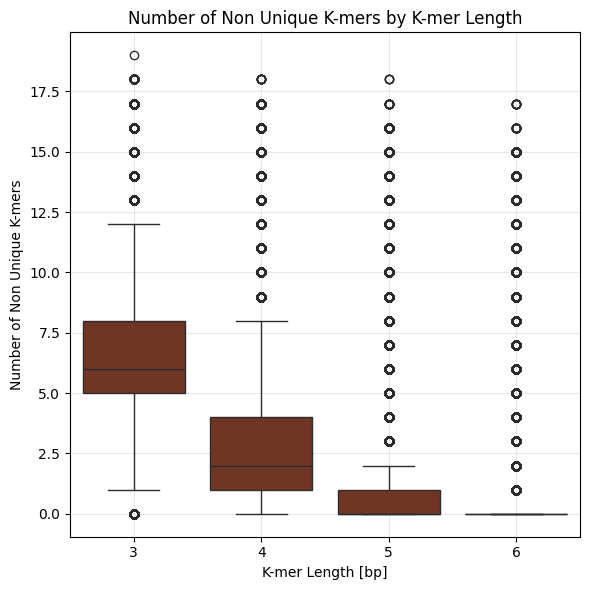

Plot saved to: /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/plots/raw_spacers_kmer_statistics_boxplots.svg


<Figure size 640x480 with 0 Axes>

In [60]:
# Create figure with subplots
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

# Number of non unique k-mers vs k-mer length
sns.boxplot(data=kmer_long, x='k_length', y='n_nonunique', ax=axes)
axes.set_title('Number of Non Unique K-mers by K-mer Length')
axes.set_xlabel('K-mer Length [bp]')
axes.set_ylabel('Number of Non Unique K-mers')
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig(f'{plots_dir}raw_spacers_kmer_statistics_boxplots.svg', dpi=300, bbox_inches='tight')
print(f"Plot saved to: {plots_dir}raw_spacers_kmer_statistics_boxplots.svg")

## Next Will use LCC from biopython
(https://github.com/biopython/biopython/blob/e451db211bdd855a5d0f1f6bba18985ffee12696/Bio/SeqUtils/lcc.py)

In [61]:
spacer_df = spacer_df.with_columns(
    pl.col("seq").map_elements(lambda x: lcc_simp(x), return_dtype=pl.Float64).alias("lcc")
)
spacer_df["lcc"].describe()

statistic,value
str,f64
"""count""",3.882812e6
"""null_count""",0.0
"""mean""",0.936244
"""std""",0.053711
"""min""",-0.0
"""25%""",0.912662
"""50%""",0.950146
"""75%""",0.974465
"""max""",1.0


### "Dust" masking


Adding a column for the number of masked bases in a spacer when using pydustmasker with a window size of 5 and a score threshold of 6.

In [62]:
score_threshold = 15
window_size = 9
spacer_df = spacer_df.with_columns(
    pl.col("seq").map_elements(lambda x: pdm.DustMasker(x, window_size=window_size, score_threshold=score_threshold).n_masked_bases, return_dtype=pl.Int64).alias("low_compx_n_masked")
    )
spacer_df["low_compx_n_masked"].value_counts().sort(by="low_compx_n_masked", descending=True)

low_compx_n_masked,count
i64,u64
38,1
36,1
35,2
34,2
33,5
31,3
30,2
29,5
28,9


And plots

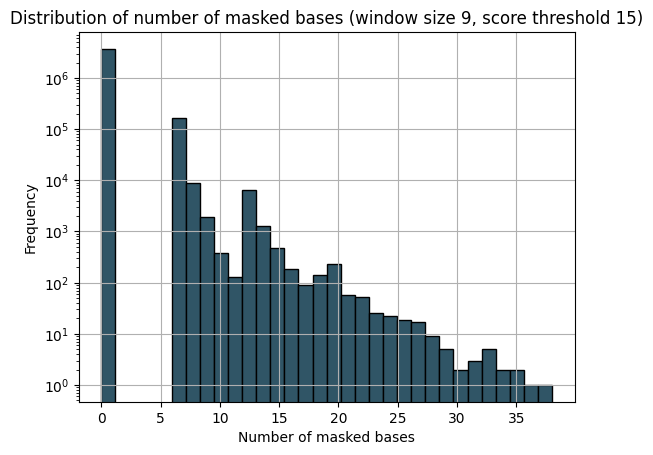

In [63]:
# histogram number of masked bases
plt.grid(True)
plt.hist(spacer_df["low_compx_n_masked"], bins=spacer_df["low_compx_n_masked"].n_unique(), edgecolor='black',log=True, color=custom_colors[4])
plt.title(f'Distribution of number of masked bases (window size {window_size}, score threshold {score_threshold})')
plt.xlabel('Number of masked bases')
plt.ylabel('Frequency')
plt.show()

## Contig (phage/viral) database inspection
in order to simulate realistic protospacer matches, we also need to inspect the real target contig set to know what GC%, length ranges, and distribution to use in the simulations. this is less crucial than the spacer set inspection, so we'll keep it brief.  
Note: We use here the HQ viral contig set from img/vr v4, or "fraction_1" from the [Prepare_all_jobs.ipynb](Prepare_all_jobs.ipynb) notebook (i.e. the largest full "real" dataset used for benchmarking).

In [23]:
real_contigs_df = pl.DataFrame(read_fasta_needletail("../results/real_data/subsamples/fraction_1/subsampled_data/subsampled_contigs.fa"), schema={'seqid': pl.Utf8, 'seq': pl.Utf8})
real_contigs_df = real_contigs_df.with_columns(
    pl.col("seq").str.len_chars().alias("length")
    )
real_contigs_df = real_contigs_df.with_columns(
    (pl.col("seq").str.count_matches("G|C|g|c")/pl.col("length")).alias("gc_frac"),
    (pl.col("seq").str.count_matches("A|a")/pl.col("length")).alias("a_frac"),
    (pl.col("seq").str.count_matches("T|t") / pl.col("length")).alias("t_frac"),
    (pl.col("seq").str.count_matches("C|c") / pl.col("length")).alias("c_frac"),
    (pl.col("seq").str.count_matches("G|g") / pl.col("length")).alias("g_frac"),
    )

../results/real_data/plots/subsampled_fraction_1_attribute_distributions.svg


statistic,a_frac,g_frac,c_frac,t_frac,gc_frac,length
str,f64,f64,f64,f64,f64,f64
"""count""",421431.0,421431.0,421431.0,421431.0,421431.0,421431.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.262247,0.237707,0.237754,0.262275,0.475461,44777.539355
"""std""",0.055971,0.052737,0.052458,0.056174,0.098861,36472.707977
"""min""",0.112459,0.073528,0.075152,0.112933,0.196868,1060.0
"""25%""",0.222684,0.198116,0.197937,0.222871,0.396754,31831.0
"""50%""",0.259072,0.238876,0.238812,0.259039,0.476079,40550.0
"""75%""",0.30002,0.274746,0.274644,0.299938,0.542844,52218.0
"""max""",0.496378,0.4491,0.448743,0.491135,0.755381,711471.0


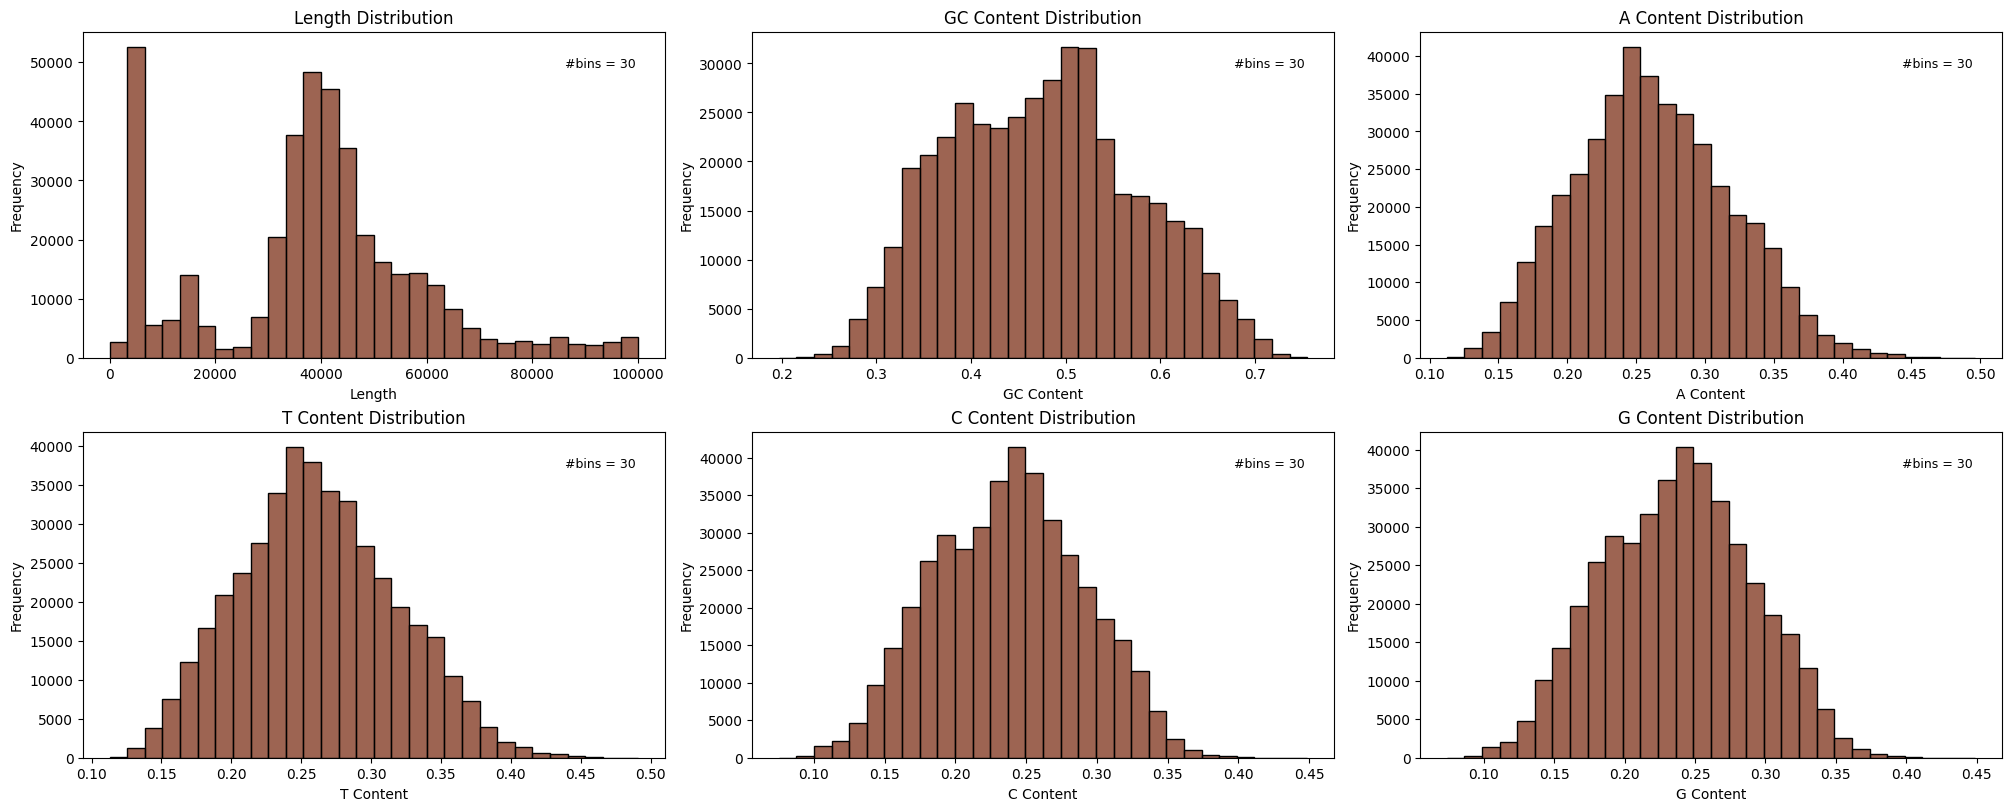

In [24]:
# quick multi facet plots for the simulated spacers (length, gc_frac, a_frac, t_frac, c_frac, g_frac, lcc, entropy, low_compx_n_masked)
fig, axes = plt.subplots(
    2, 3,
    figsize=(20, 8),
    constrained_layout=True      # adds extra space so titles/labels don’t overlap
)

# Helper to annotate a subplot with its bin count
def _add_bin_annotation(ax, bin_count, ha="right"):
    # place the text in the top‑right corner of the axes
    ax.text(
        0.95 if ha == "right" else 0.05,
        0.92,
        f"#bins = {bin_count}",
        transform=ax.transAxes,
        fontsize=9,
        ha=ha,
        va="top",
        color="black",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7)   # make it readable
    )

# Length distribution
bins_len = 30
sns.histplot(real_contigs_df, x="length", bins=bins_len, ax=axes[0, 0],binrange=(0, 100000))
axes[0, 0].set_title('Length Distribution')
axes[0, 0].set_xlabel('Length')
axes[0, 0].set_ylabel('Frequency')
_add_bin_annotation(axes[0, 0], bins_len)

# GC content distribution
bins_gc = 30
sns.histplot(real_contigs_df, x="gc_frac", bins=bins_gc, ax=axes[0, 1])
axes[0, 1].set_title('GC Content Distribution')
axes[0, 1].set_xlabel('GC Content')
axes[0, 1].set_ylabel('Frequency')
_add_bin_annotation(axes[0, 1], bins_gc)

# A content distribution
bins_a = 30
sns.histplot(real_contigs_df, x="a_frac", bins=bins_a, ax=axes[0, 2])
axes[0, 2].set_title('A Content Distribution')
axes[0, 2].set_xlabel('A Content')
axes[0, 2].set_ylabel('Frequency')
_add_bin_annotation(axes[0, 2], bins_a)

# T content distribution
bins_t = 30
sns.histplot(real_contigs_df, x="t_frac", bins=bins_t, ax=axes[1, 0])
axes[1, 0].set_title('T Content Distribution')
axes[1, 0].set_xlabel('T Content')
axes[1, 0].set_ylabel('Frequency')
_add_bin_annotation(axes[1, 0], bins_t)
# C content distribution
bins_c = 30
sns.histplot(real_contigs_df, x="c_frac", bins=bins_c, ax=axes[1, 1])
axes[1, 1].set_title('C Content Distribution')
axes[1, 1].set_xlabel('C Content')
axes[1, 1].set_ylabel('Frequency')
_add_bin_annotation(axes[1, 1], bins_c)
# G content distribution (note: same axes[0,4] was previously overwritten)
bins_g = 30
sns.histplot(real_contigs_df, x="g_frac", bins=bins_g, ax=axes[1, 2])
axes[1, 2].set_title('G Content Distribution')
axes[1, 2].set_xlabel('G Content')
axes[1, 2].set_ylabel('Frequency')
_add_bin_annotation(axes[1, 2], bins_g)


plt.savefig("../results/real_data/plots/" + 'subsampled_fraction_1_attribute_distributions.svg')
print("../results/real_data/plots/" + 'subsampled_fraction_1_attribute_distributions.svg')
real_contigs_df["a_frac","g_frac","c_frac","t_frac","gc_frac","length"].describe()

## Comparison with simulated spacers and contigs

For comparisson, we'll simulate several fully synthetic contig and spacer sets, selecting paramteres to match the length, GC ranges, and distribution types via our rust_simulater ( see `pixi run "spacer_bencher simulate --help"` for more details).

In [16]:
# %%bash
# # 50_000 spacers, 5_000 contigs, 1-5 insertions, 25-40 spacer length, 10000-150000 contig length, 0-5 mismatches
# pixi run "spacer_bencher simulate --contig-distribution normal  --spacer-distribution normal --num-spacers 50000 --gc-content 49 --spacer-insertions 1 5 --num-contigs 5000 --spacer-length 25 40  --contig-length 10000 150000 --mismatch-range 0 5 --output-dir ../results/simulated/ns_50000_nc_5000/ --threads 8"

# # 75_000 spacers, 5_000 contigs, 1-5 insertions, 25-40 spacer length, 10000-150000 contig length, 0-5 mismatches
# pixi run "spacer_bencher simulate --contig-distribution normal  --spacer-distribution normal --num-spacers 75000 --gc-content 49 --spacer-insertions 1 5 --num-contigs 5000 --spacer-length 25 40  --contig-length 10000 150000 --mismatch-range 0 5 --output-dir ../results/simulated/ns_75000_nc_5000/ --threads 8"

# # 75_000 spacers, 10_000 contigs, 1-5 insertions, 25-40 spacer length, 10000-150000 contig length, 0-5 mismatches
# pixi run "spacer_bencher simulate --contig-distribution normal  --spacer-distribution normal --num-spacers 75000 --gc-content 49 --spacer-insertions 1 5 --num-contigs 10000 --spacer-length 25 40  --contig-length 10000 150000 --mismatch-range 0 5 --output-dir ../results/simulated/ns_75000_nc_10000/ --threads 8"

# # 100_000 spacers, 10_000 contigs, 1-5 insertions, 25-40 spacer length, 10000-150000 contig length, 0-5 mismatches
# pixi run "spacer_bencher simulate --contig-distribution normal  --spacer-distribution normal --num-spacers 100000 --gc-content 49 --spacer-insertions 1 5 --num-contigs 10000 --spacer-length 25 40  --contig-length 10000 150000 --mismatch-range 0 5 --output-dir ../results/simulated/ns_100000_nc_10000/ --threads 4"

# # 100_000 spacers, 20_000 contigs, 1-5 insertions, 25-40 spacer length, 10000-150000 contig length, 0-5 mismatches
# pixi run "spacer_bencher simulate --contig-distribution normal  --spacer-distribution normal --num-spacers 100000 --gc-content 49 --spacer-insertions 1 5 --num-contigs 20000 --spacer-length 25 40  --contig-length 10000 150000 --mismatch-range 0 5 --output-dir ../results/simulated/ns_100000_nc_20000/ --threads 8"

# # # 1_000_000 spacers, 100_000 contigs, 1-5 insertions, 25-40 spacer length, 10000-150000 contig length, 0-5 mismatches
# pixi run "spacer_bencher simulate --contig-distribution normal  --spacer-distribution normal --num-spacers 1000000 --gc-content 49 --spacer-insertions 1 5 --num-contigs 100000 --spacer-length 25 40  --contig-length 10000 150000 --mismatch-range 0 5 --output-dir ../results/simulated/ns_1000000_nc_100000/ --threads 8"

# # real spacers, 20k simulated contigs, 20000 contigs, 1-5 insertions, 25-40 spacer length, 10000-250000 contig length, 0-5 mismatches
# pixi run "spacer_bencher simulate --contig-distribution normal --spacers  imgvr4_data/spacers/All_CRISPR_spacers_nr_clean.fna --num-spacers 1000000 --contig-gc-content 46 --spacer-insertions 1 5 --num-contigs 20000  --contig-length 10000 150000 --mismatch-range 0 5 --output-dir ./results/simulated/ns_1000000_nc_20000_real/ --threads 8"

# # next generating scripts and running for these is below

## Showcasing the simulated spacers match the real ones 
Using the 100k spacers and 20k contigs set (the largest fully synthetic set we generated, for now)

In [39]:
# reminder - pydustmasker values
score_threshold = 15
window_size = 9
simulated_spacers_df = pl.DataFrame(read_fasta_needletail("../results/simulated/ns_100000_nc_20000/simulated_data/simulated_spacers.fa"), schema={'seqid': pl.Utf8, 'seq': pl.Utf8})
simulated_spacers_df = simulated_spacers_df.with_columns(
    pl.col("seq").str.len_chars().alias("length")
    )
simulated_spacers_df = simulated_spacers_df.with_columns(
    (pl.col("seq").str.count_matches("G|C|g|c")/pl.col("length")).alias("gc_frac"),
    (pl.col("seq").str.count_matches("A|a")/pl.col("length")).alias("a_frac"),
    (pl.col("seq").str.count_matches("T|t") / pl.col("length")).alias("t_frac"),
    (pl.col("seq").str.count_matches("C|c") / pl.col("length")).alias("c_frac"),
    (pl.col("seq").str.count_matches("G|g") / pl.col("length")).alias("g_frac"),
    pl.col("seq").map_elements(lambda x: pdm.DustMasker(x, window_size=window_size, score_threshold=score_threshold).n_masked_bases, return_dtype=pl.Int64).alias("low_compx_n_masked"),
    pl.col("seq").map_elements(lambda x: lcc_simp(x), return_dtype=pl.Float64).alias("lcc"),
    pl.col("seq").map_elements(calculate_shannon_entropy, return_dtype=pl.Float64).alias("entropy"),
        )
# kmers 
for k in range(3, 7):
    tmp_df = count_kmers_df_explicit(simulated_spacers_df, "seq", "seqid", k, relative=False)
    tmp_df = tmp_df.select(
        pl.col(f"kmer_{k}_counts").list.eval(
            (pl.element().struct.field("count") > 1).sum()
        ).list.first().alias(f"n_nonunique_kmer_{k}"),
    )
    simulated_spacers_df = simulated_spacers_df.with_columns(
        tmp_df[f"n_nonunique_kmer_{k}"].alias(f"n_nonunique_kmer_{k}")
    )
    del tmp_df # this can get big, and python GC won't know we treat it as a tmp variable...
    print(f"k={k} done")

#first transform the data to long format
simulated_kmer_df = simulated_spacers_df.select(
    pl.col("seqid"),
    pl.col("n_nonunique_kmer_3"),
    pl.col("n_nonunique_kmer_4"),
    pl.col("n_nonunique_kmer_5"),
    pl.col("n_nonunique_kmer_6"),
    pl.col("length"),
)
# Reshape data for plotting - convert to long format # TODO: think of a  programmatic way to do this (instead of explicitly writing out each kmer length)
simulated_kmer_long = pl.concat([
    simulated_kmer_df.select([
        pl.col("seqid"),
        pl.col("n_nonunique_kmer_3").alias("n_nonunique"),
        pl.col("length").alias("length"),
        pl.lit(3).alias("k_length")
    ]),
    simulated_kmer_df.select([
        pl.col("seqid"),
        pl.col("n_nonunique_kmer_4").alias("n_nonunique"),
        pl.col("length").alias("length"),
        pl.lit(4).alias("k_length")
    ]),
    simulated_kmer_df.select([
        pl.col("seqid"),
        pl.col("n_nonunique_kmer_5").alias("n_nonunique"),
        pl.col("length").alias("length"),
        pl.lit(5).alias("k_length")
    ]),
    simulated_kmer_df.select([
        pl.col("seqid"),
        pl.col("n_nonunique_kmer_6").alias("n_nonunique"),
        pl.col("length").alias("length"),
        pl.lit(6).alias("k_length")
    ]),
])

NeedletailError: I/O error: No such file or directory (os error 2)

And plots for comparison:

/tmp/ipykernel_4090610/184677228.py:101: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


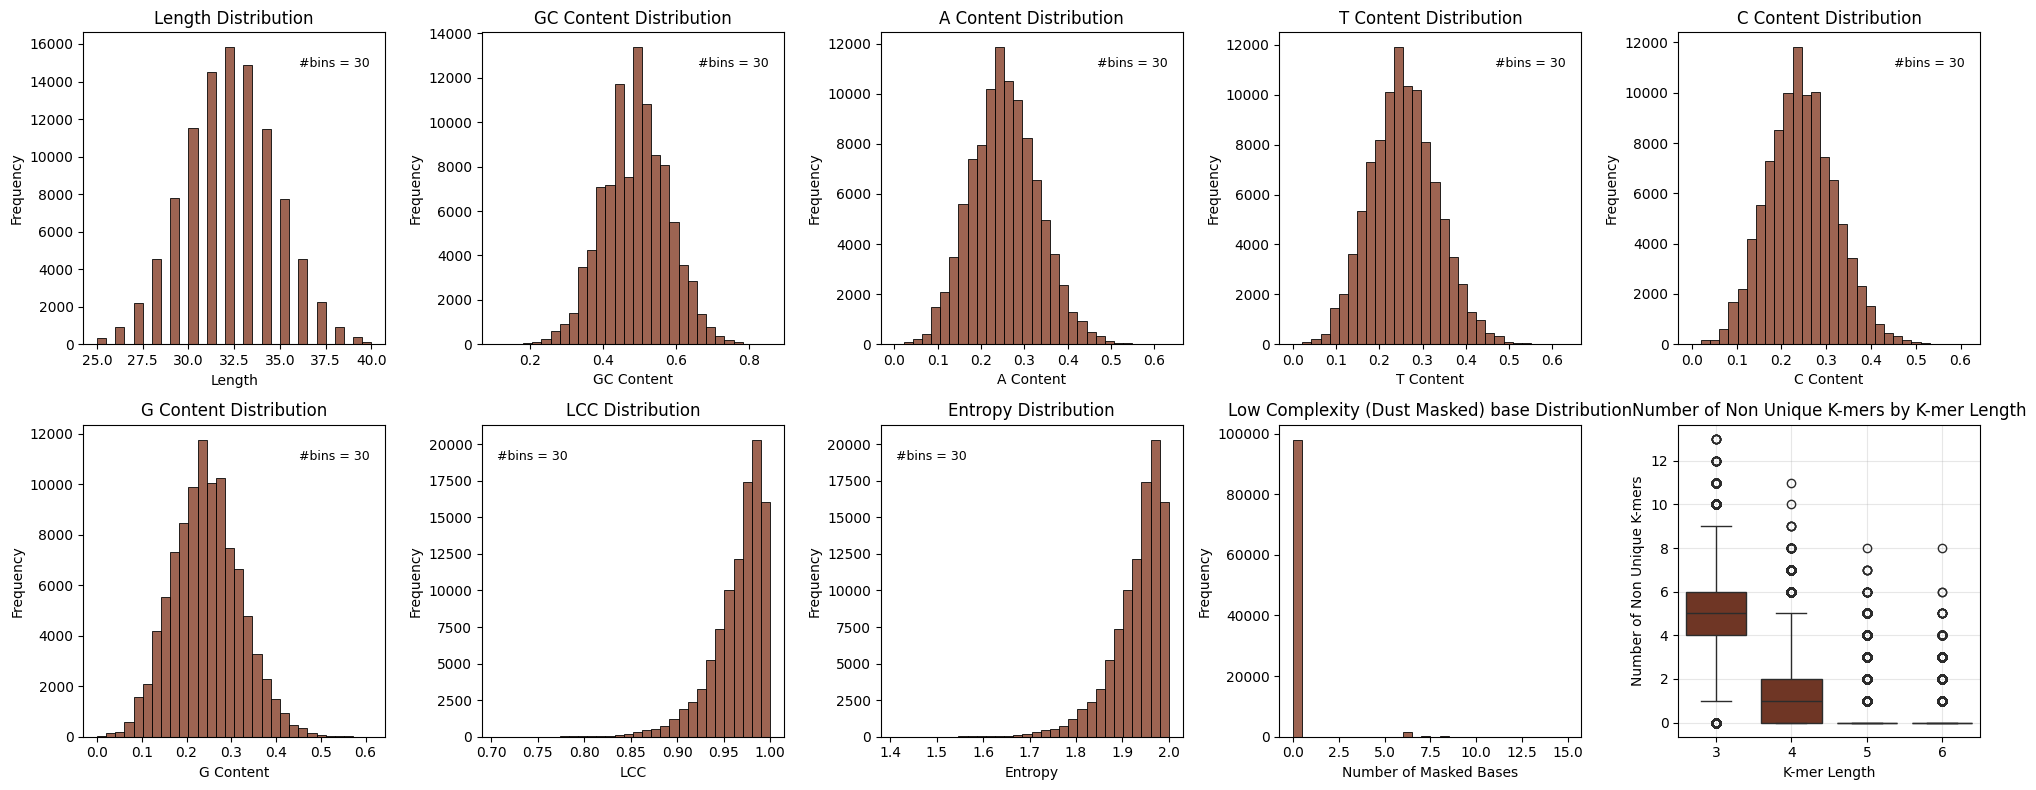

../results/simulated/ns_100000_nc_20000/plots/simulated_spacers_attribute_distributions.svg


<Figure size 640x480 with 0 Axes>

In [18]:
# quick multi facet plots for the simulated spacers (length, gc_frac, a_frac, t_frac, c_frac, g_frac, lcc, entropy, low_compx_n_masked)
fig, axes = plt.subplots(
    2, 5,
    figsize=(20, 8),
    constrained_layout=True      # adds extra space so titles/labels don’t overlap
)

# Helper to annotate a subplot with its bin count
def _add_bin_annotation(ax, bin_count, ha="right"):
    # place the text in the top‑right corner of the axes
    ax.text(
        0.95 if ha == "right" else 0.05,
        0.92,
        f"#bins = {bin_count}",
        transform=ax.transAxes,
        fontsize=9,
        ha=ha,
        va="top",
        color="black",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7)   # make it readable
    )

# Length distribution
bins_len = 30
sns.histplot(simulated_spacers_df, x="length", bins=bins_len, ax=axes[0, 0])
axes[0, 0].set_title('Length Distribution')
axes[0, 0].set_xlabel('Length')
axes[0, 0].set_ylabel('Frequency')
_add_bin_annotation(axes[0, 0], bins_len)

# GC content distribution
bins_gc = 30
sns.histplot(simulated_spacers_df, x="gc_frac", bins=bins_gc, ax=axes[0, 1])
axes[0, 1].set_title('GC Content Distribution')
axes[0, 1].set_xlabel('GC Content')
axes[0, 1].set_ylabel('Frequency')
_add_bin_annotation(axes[0, 1], bins_gc)

# A content distribution
bins_a = 30
sns.histplot(simulated_spacers_df, x="a_frac", bins=bins_a, ax=axes[0, 2])
axes[0, 2].set_title('A Content Distribution')
axes[0, 2].set_xlabel('A Content')
axes[0, 2].set_ylabel('Frequency')
_add_bin_annotation(axes[0, 2], bins_a)

# T content distribution
bins_t = 30
sns.histplot(simulated_spacers_df, x="t_frac", bins=bins_t, ax=axes[0, 3])
axes[0, 3].set_title('T Content Distribution')
axes[0, 3].set_xlabel('T Content')
axes[0, 3].set_ylabel('Frequency')
_add_bin_annotation(axes[0, 3], bins_t)

# C content distribution
bins_c = 30
sns.histplot(simulated_spacers_df, x="c_frac", bins=bins_c, ax=axes[0, 4])
axes[0, 4].set_title('C Content Distribution')
axes[0, 4].set_xlabel('C Content')
axes[0, 4].set_ylabel('Frequency')
_add_bin_annotation(axes[0, 4], bins_c)

# G content distribution (note: same axes[0,4] was previously overwritten)
bins_g = 30
sns.histplot(simulated_spacers_df, x="g_frac", bins=bins_g, ax=axes[1, 0])
axes[1, 0].set_title('G Content Distribution')
axes[1, 0].set_xlabel('G Content')
axes[1, 0].set_ylabel('Frequency')
_add_bin_annotation(axes[1, 0], bins_g)

# LCC distribution
bins_lcc = 30
sns.histplot(simulated_spacers_df, x="lcc", bins=bins_lcc, ax=axes[1, 1])
axes[1, 1].set_title('LCC Distribution')
axes[1, 1].set_xlabel('LCC')
axes[1, 1].set_ylabel('Frequency')
_add_bin_annotation(axes[1, 1], bins_lcc, ha="left")

# Entropy distribution
bins_entropy = 30
sns.histplot(simulated_spacers_df, x="entropy", bins=bins_entropy, ax=axes[1, 2])
axes[1, 2].set_title('Entropy Distribution')
axes[1, 2].set_xlabel('Entropy')
axes[1, 2].set_ylabel('Frequency')
_add_bin_annotation(axes[1, 2], bins_entropy, ha="left")

# Low‑complexity (Dust‑masked) k‑mer distribution
bins_dust = 30
sns.histplot(simulated_spacers_df, x="low_compx_n_masked", bins=bins_dust, ax=axes[1, 3])
axes[1, 3].set_title('Low Complexity (Dust Masked) base Distribution')
axes[1, 3].set_xlabel('Number of Masked Bases')
axes[1, 3].set_ylabel('Frequency')

# # Plot kmer counts distribution WIP
# Number of non unique k-mers vs k-mer length
sns.boxplot(data=simulated_kmer_long, x='k_length', y='n_nonunique', ax=axes[1, 4])
axes[1, 4].set_title('Number of Non Unique K-mers by K-mer Length')
axes[1, 4].set_xlabel('K-mer Length')
axes[1, 4].set_ylabel('Number of Non Unique K-mers')
axes[1, 4].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# sns.histplot(simulated_spacers_df, x="kmer_2_counts", bins=30, ax=axes[1, 3])
# axes[1, 3].set_title('Kmer Counts Distribution')
# axes[1, 3].set_xlabel('Number of Kmers')
# axes[1, 3].set_ylabel('Frequency')

plt.savefig("../results/simulated/ns_100000_nc_20000/plots/" + 'simulated_spacers_attribute_distributions.svg')
print("../results/simulated/ns_100000_nc_20000/plots/" + 'simulated_spacers_attribute_distributions.svg')


And for the simulated contigs:

../results/real_data/plots/subsampled_fraction_1_attribute_distributions.svg


statistic,a_frac,g_frac,c_frac,t_frac,gc_frac,length
str,f64,f64,f64,f64,f64,f64
"""count""",476976.0,476976.0,476976.0,476976.0,476976.0,476976.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.263871,0.236378,0.236175,0.263559,0.472553,40446.793782
"""std""",0.054739,0.051526,0.051496,0.054733,0.096325,37775.822417
"""min""",0.097844,0.073528,0.075152,0.107516,0.177812,165.0
"""25%""",0.225861,0.198294,0.197428,0.225894,0.397432,12975.0
"""50%""",0.261601,0.237145,0.236876,0.261137,0.472459,38671.0
"""75%""",0.300832,0.271751,0.271645,0.300144,0.53641,49633.0
"""max""",0.496378,0.4491,0.498942,0.491135,0.787728,2.47387e6


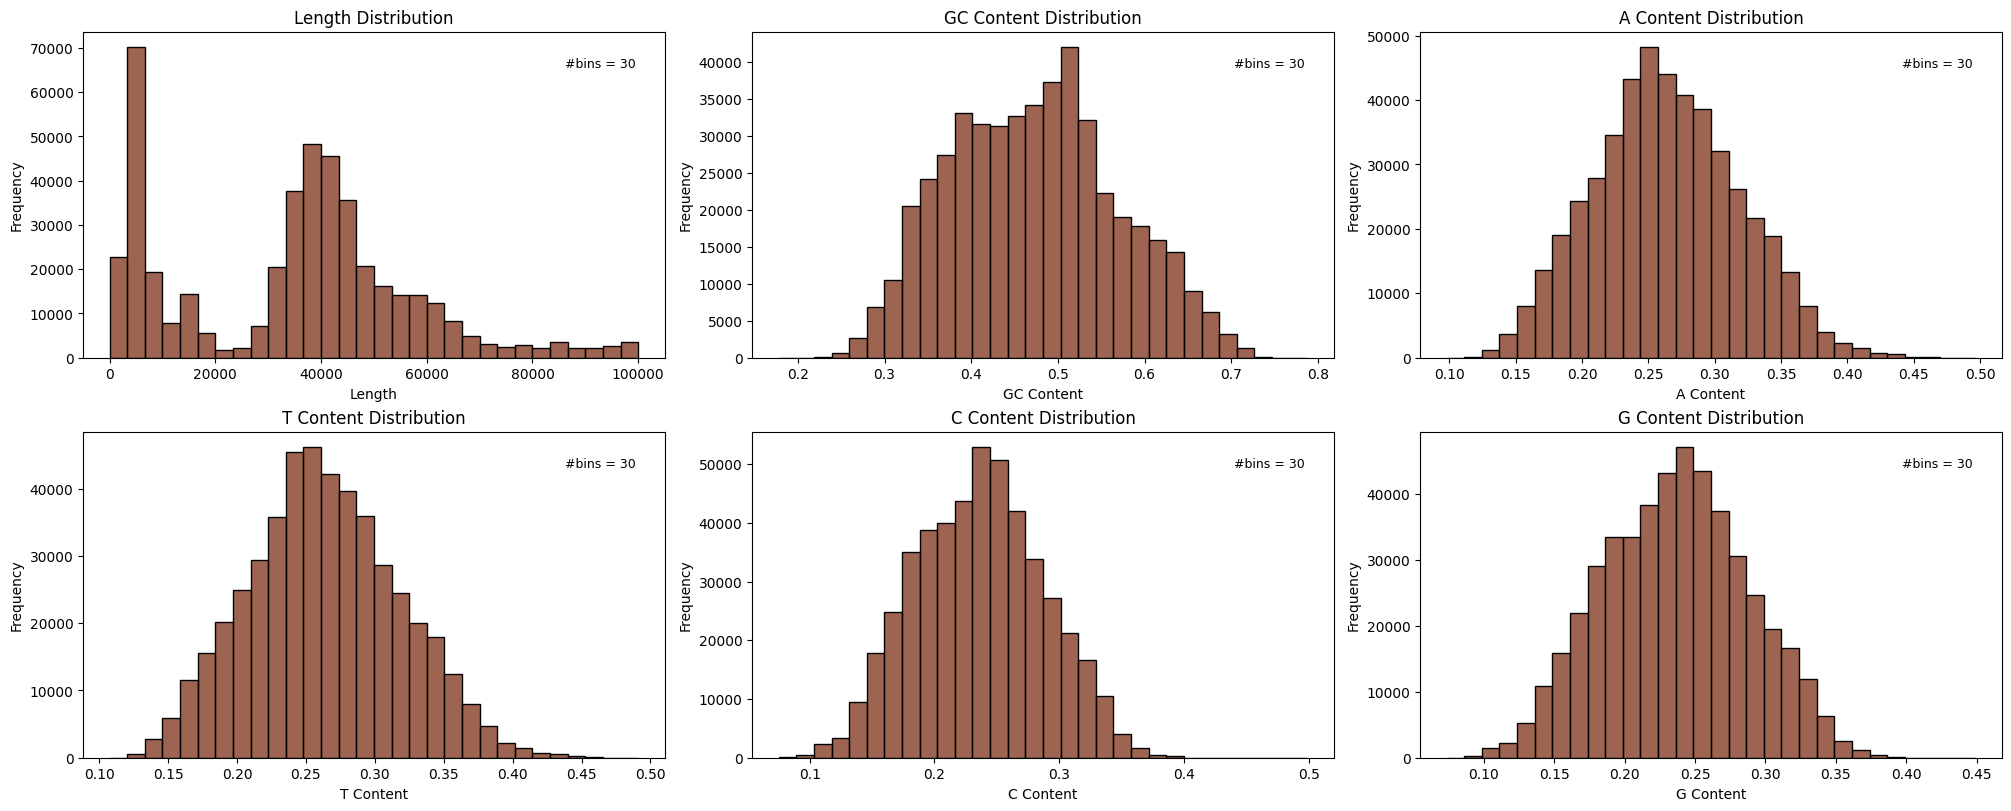

In [20]:
simulated_contigs_df = pl.DataFrame(read_fasta_needletail("../results/simulated/ns_100000_nc_20000/simulated_data/simulated_contigs.fa"), schema={'seqid': pl.Utf8, 'seq': pl.Utf8})

simulated_contigs_df = simulated_contigs_df.with_columns(
    pl.col("seq").str.len_chars().alias("length")
    )
simulated_contigs_df = simulated_contigs_df.with_columns(
    (pl.col("seq").str.count_matches("G|C|g|c")/pl.col("length")).alias("gc_frac"),
    (pl.col("seq").str.count_matches("A|a")/pl.col("length")).alias("a_frac"),
    (pl.col("seq").str.count_matches("T|t") / pl.col("length")).alias("t_frac"),
    (pl.col("seq").str.count_matches("C|c") / pl.col("length")).alias("c_frac"),
    (pl.col("seq").str.count_matches("G|g") / pl.col("length")).alias("g_frac"),
        )

# quick multi facet plots for the simulated spacers (length, gc_frac, a_frac, t_frac, c_frac, g_frac, lcc, entropy, low_compx_n_masked)
fig, axes = plt.subplots(
    2, 3,
    figsize=(20, 8),
    constrained_layout=True      # adds extra space so titles/labels don’t overlap
)

# Helper to annotate a subplot with its bin count
def _add_bin_annotation(ax, bin_count, ha="right"):
    # place the text in the top‑right corner of the axes
    ax.text(
        0.95 if ha == "right" else 0.05,
        0.92,
        f"#bins = {bin_count}",
        transform=ax.transAxes,
        fontsize=9,
        ha=ha,
        va="top",
        color="black",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7)   # make it readable
    )

# Length distribution
bins_len = 30
sns.histplot(real_contigs_df, x="length", bins=bins_len, ax=axes[0, 0],binrange=(0, 100000))
axes[0, 0].set_title('Length Distribution')
axes[0, 0].set_xlabel('Length')
axes[0, 0].set_ylabel('Frequency')
_add_bin_annotation(axes[0, 0], bins_len)

# GC content distribution
bins_gc = 30
sns.histplot(real_contigs_df, x="gc_frac", bins=bins_gc, ax=axes[0, 1])
axes[0, 1].set_title('GC Content Distribution')
axes[0, 1].set_xlabel('GC Content')
axes[0, 1].set_ylabel('Frequency')
_add_bin_annotation(axes[0, 1], bins_gc)

# A content distribution
bins_a = 30
sns.histplot(real_contigs_df, x="a_frac", bins=bins_a, ax=axes[0, 2])
axes[0, 2].set_title('A Content Distribution')
axes[0, 2].set_xlabel('A Content')
axes[0, 2].set_ylabel('Frequency')
_add_bin_annotation(axes[0, 2], bins_a)

# T content distribution
bins_t = 30
sns.histplot(real_contigs_df, x="t_frac", bins=bins_t, ax=axes[1, 0])
axes[1, 0].set_title('T Content Distribution')
axes[1, 0].set_xlabel('T Content')
axes[1, 0].set_ylabel('Frequency')
_add_bin_annotation(axes[1, 0], bins_t)
# C content distribution
bins_c = 30
sns.histplot(real_contigs_df, x="c_frac", bins=bins_c, ax=axes[1, 1])
axes[1, 1].set_title('C Content Distribution')
axes[1, 1].set_xlabel('C Content')
axes[1, 1].set_ylabel('Frequency')
_add_bin_annotation(axes[1, 1], bins_c)
# G content distribution (note: same axes[0,4] was previously overwritten)
bins_g = 30
sns.histplot(real_contigs_df, x="g_frac", bins=bins_g, ax=axes[1, 2])
axes[1, 2].set_title('G Content Distribution')
axes[1, 2].set_xlabel('G Content')
axes[1, 2].set_ylabel('Frequency')
_add_bin_annotation(axes[1, 2], bins_g)

plt.savefig("../results/real_data/plots/" + 'subsampled_fraction_1_attribute_distributions.svg')
print("../results/real_data/plots/" + 'subsampled_fraction_1_attribute_distributions.svg')
real_contigs_df["a_frac","g_frac","c_frac","t_frac","gc_frac","length"].describe()

As we can see, the simulated spacers present roughly similar sequence attribute distribution with regards to base composition as the real spacers from the iphop db.  
A caveat is that the simulated sequences have less outliers, i.e. sequences with very high or low (compared to the mean) values for the different features.  
Overall the real spacers appear to have some more low complexity outliers (slightly lower entropy values on avg) but the mass of the spacers (in both real and simulated) are above the same 1.3~ value. Our simulated sequences do not have any `N` bases, which could explain some of this variation, and we have decided to remove any spacer from the iphop database that has any N's or homo polymers, so this might be elivated a little.

<!-- We'll copy them into the results/simulated/ path to use in the mapping comparison. # no need already moved where it is written to there -->
<!-- We'll further curate the spacer set by filtering out very low complexity sequences:   -->
<!-- - no more than 10% of the spacer is Ns
- no 6mers found more than 3 times.
- no 5mers found more than 5 times.
- All bases are A, T, C, or G must be present.
- Shannon entropy > 1.2 (?)
- pydustmasker with a window size of 9 and a score threshold of 15 has no masked bases. -->


### total search sizes
(commented out)
<!-- using the inforamtion from the log of the spacer_bench simulator (verified with seqkit stats), the total number of contigs and bases are:
```bash
Total planned insertion length: 9603920 bp
Average insertions per spacer: 3.0
Total contig size: 801826585 bp

```

This means that if we want to generalise an "expected" value (how many alignment passing our threshold would we expect to see between our sequences and a (random) dataset of nnn length - by chance alone), it would be the total amount of the non-planned spacer-insertions (identified by all tools as a proxy) out of the 792,222,665 (801826585 - 9603920) bases not used in the search... -->

Finally, we'll save the lightly cleaned spacer sequences and their stats.

In [65]:
spacer_df1 = spacer_df.filter(
    (pl.col("n_frac" ) == 0),
    (pl.col("a_frac") < 0.95),
    (pl.col("g_frac") < 0.95 ),
    (pl.col("c_frac") < 0.95 ),
    (pl.col("t_frac") < 0.95),
    (pl.col("gc_frac") < 0.95),
    (pl.col("entropy") > 1),
    (pl.col("n_nonunique_kmer_6") < 4),
)
print((spacer_df.height- spacer_df1.height))
print(100 -((spacer_df.height- spacer_df1.height)/spacer_df.height)*100)
spacer_df = spacer_df1

55833
98.5620472997405


In [66]:
# save the spacer_df as parquet
spacer_df.write_parquet("/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/imgvr4_data/spacers/spacers_stats.parquet")
# save sequences to fasta
write_fasta(
    filename="/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/imgvr4_data/spacers/iphop_filtered_spacers.fna",
    sequences=dict(zip(spacer_df["seqid"], spacer_df["seq"]))
    )

Next up - see Performence_simulated.ipynb
